In [29]:
# import libraries
# python staples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
# scikitlearn

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
# seaborn plotting
import seaborn as sns
# use matplot |in jupyter notebook
%matplotlib inline

In [38]:
def confusion_summary_binary(y_actual, y_pred, verbose):
    # get success and failur
    tot_tested = len(y_actual)
    tot_success = sum( y_actual )
    tot_fail = tot_tested - tot_success
    pred_success = sum( y_pred )
    pred_fail = tot_tested - pred_success
    # see how you did
    confusion_mat = confusion_matrix(y_actual, y_pred)
    confusion_mat_norm = confusion_mat / tot_tested
    accuracy = confusion_mat_norm[0,0] + confusion_mat_norm[1,1]
    recall = confusion_mat[0,0] / tot_success
    precision = confusion_mat[0,1] / pred_success
    f1 = 2 / ( 1/recall + 1/precision)
    summary = {"confusion": confusion_mat, "confusion_norm": confusion_mat_norm,
               "recall": recall, "precision": precision, "f1": f1,
               "accuracy": accuracy}
    if verbose == 1:
        print('accuracy = ', accuracy )
        print('recall = ', recall )
        print('precision = ', precision )
        print('f1 =', f1  )
    return summary

def clean_data( mydata, drop_list, verbose ):
    # clean cabin
#     mydata.Cabin = mydata.Cabin.fillna('N')
#     mydata.Cabin = mydata.Cabin.apply(lambda y: y[0])
# #     pd.get_dummies()
#     mydata.loc[mydata.Cabin == 'A','Sex' ] = 1
#     mydata.loc[mydata.Cabin == 'B','Sex' ] = 2
#     mydata.loc[mydata.Cabin == 'C','Sex' ] = 3
#     mydata.loc[mydata.Cabin == 'D','Sex' ] = 4
#     mydata.loc[mydata.Cabin == 'E','Sex' ] = 5
#     mydata.loc[mydata.Cabin == 'F','Sex' ] = 6
#     mydata.loc[mydata.Cabin == 'G','Sex' ] = 7
#     mydata.loc[mydata.Cabin == 'T','Sex' ] = 8
#     mydata.loc[mydata.Cabin == 'N','Sex' ] = 9
    # some data is pointless, get rid of id
    mydata = mydata.drop( drop_list, axis=1 )
    # clean it
    # find isnan value
    if verbose == 1:
        print( 'before clean isnan check:\n', mydata.isna().any() )
    # turn male/female, embarked to a number
    mydata.loc[mydata.Sex == 'female','Sex' ] = 0
    mydata.loc[mydata.Sex == 'male','Sex' ] = 1
    mydata.loc[mydata.Embarked == 'S','Embarked' ] = 0
    mydata.loc[mydata.Embarked == 'C','Embarked' ] = 1
    mydata.loc[mydata.Embarked == 'Q','Embarked' ] = 2
    # replace nan with average
    mydata.loc[mydata.Age.isnull(),'Age']  = np.mean( mydata.Age[~mydata.Age.isna()] )
    mydata.loc[mydata.Fare.isnull(),'Fare']  = np.mean( mydata.Fare[~mydata.Fare.isna()] )
    mydata.loc[mydata.Embarked.isna(),'Embarked'] = mydata.mode().Embarked[0]
    #normalize
    mydata = ( mydata - mydata.mean() ) / mydata.std()
    if verbose:
        print('after clean isnan check:\n', mydata.isna().any() )
        print( 'Cleaned data:', mydata.iloc[0] )
    return mydata

def sklearn_fit( fitmodel, x_train, y_train, x_cv, y_cv, verbose ):
    fitmodel.fit(x_train, y_train)
    prediction = fitmodel.predict(x_cv)
    accuracy = get_accuracy( y_cv, prediction )
    model = {'prediction': prediction, 'accuracy': accuracy }
    return model

def get_accuracy( y_actual, y_pred ):
    return np.sum( y_actual == y_pred) / np.size( y_actual)

def get_rand_train_inds( num_points, train_frac ):
        num_train = np.round( num_tot * train_frac )
        ind_all = np.arange(num_points)
        ind_train = np.random.choice(int(num_points), int(num_train), replace=False)
        ind_cv = np.delete( ind_all, ind_train )
        return ind_train, ind_cv

In [50]:
# grab the data and put it in a pandas dataframe
df_train_all = pd.read_csv('train.csv')
df_test_all = pd.read_csv('test.csv')
# print some info
print('Original train data set:\n\n', df_train_all.iloc[0])
print('Original test data set:\n\n', df_test_all.iloc[0])
num_features = len( df_train_all.columns ) - 1
print('\n features:', num_features, 'num_train', len(df_train_all.PassengerId),
      'num_test', len(df_test_all.PassengerId) )

Original train data set:

 PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object
Original test data set:

 PassengerId                 892
Pclass                        3
Name           Kelly, Mr. James
Sex                        male
Age                        34.5
SibSp                         0
Parch                         0
Ticket                   330911
Fare                     7.8292
Cabin                       NaN
Embarked                      Q
Name: 0, dtype: object

 features: 11 num_train 891 num_test 418


In [52]:
# clean data
drop_list = ['PassengerId','Name','Ticket', 'Cabin']
# break the y data to train, validation set
train_frac = 0.66;
num_tot = len( df_train_all.index)
y_train = df_train_all.Survived
# clean it
df_data = clean_data( df_train_all, drop_list, 0)
#df_data.Survived = y_train
# separate into training sets
x_data = df_data.drop( 'Survived', axis=1 )
#x_train = x_data.iloc[ind_train]
x_train = x_data
# x_cv = x_data.iloc[ind_cv]
x_test = clean_data( df_test_all, drop_list, 0)
# print some info
num_features_test = len( x_test.columns )
num_features_train = len( x_train.columns )
print( 'Data set:\n', x_train.iloc[0])
print( 'Data set:\n', x_test.iloc[0])
print('\n test samples:', len( x_test.index) )
print('\n train samples:', len( x_train.index) )
print('\n features:', num_features_test, num_features_train )

Data set:
 Pclass      0.826913
Sex         0.737281
Age        -0.592148
SibSp       0.432550
Parch      -0.473408
Fare       -0.502163
Embarked   -0.568518
Name: 0, dtype: float64
Data set:
 Pclass      0.872436
Sex         0.755024
Age         0.334592
SibSp      -0.498872
Parch      -0.399769
Fare       -0.497811
Embarked    2.240480
Name: 0, dtype: float64

 test samples: 418

 train samples: 891

 features: 7 7


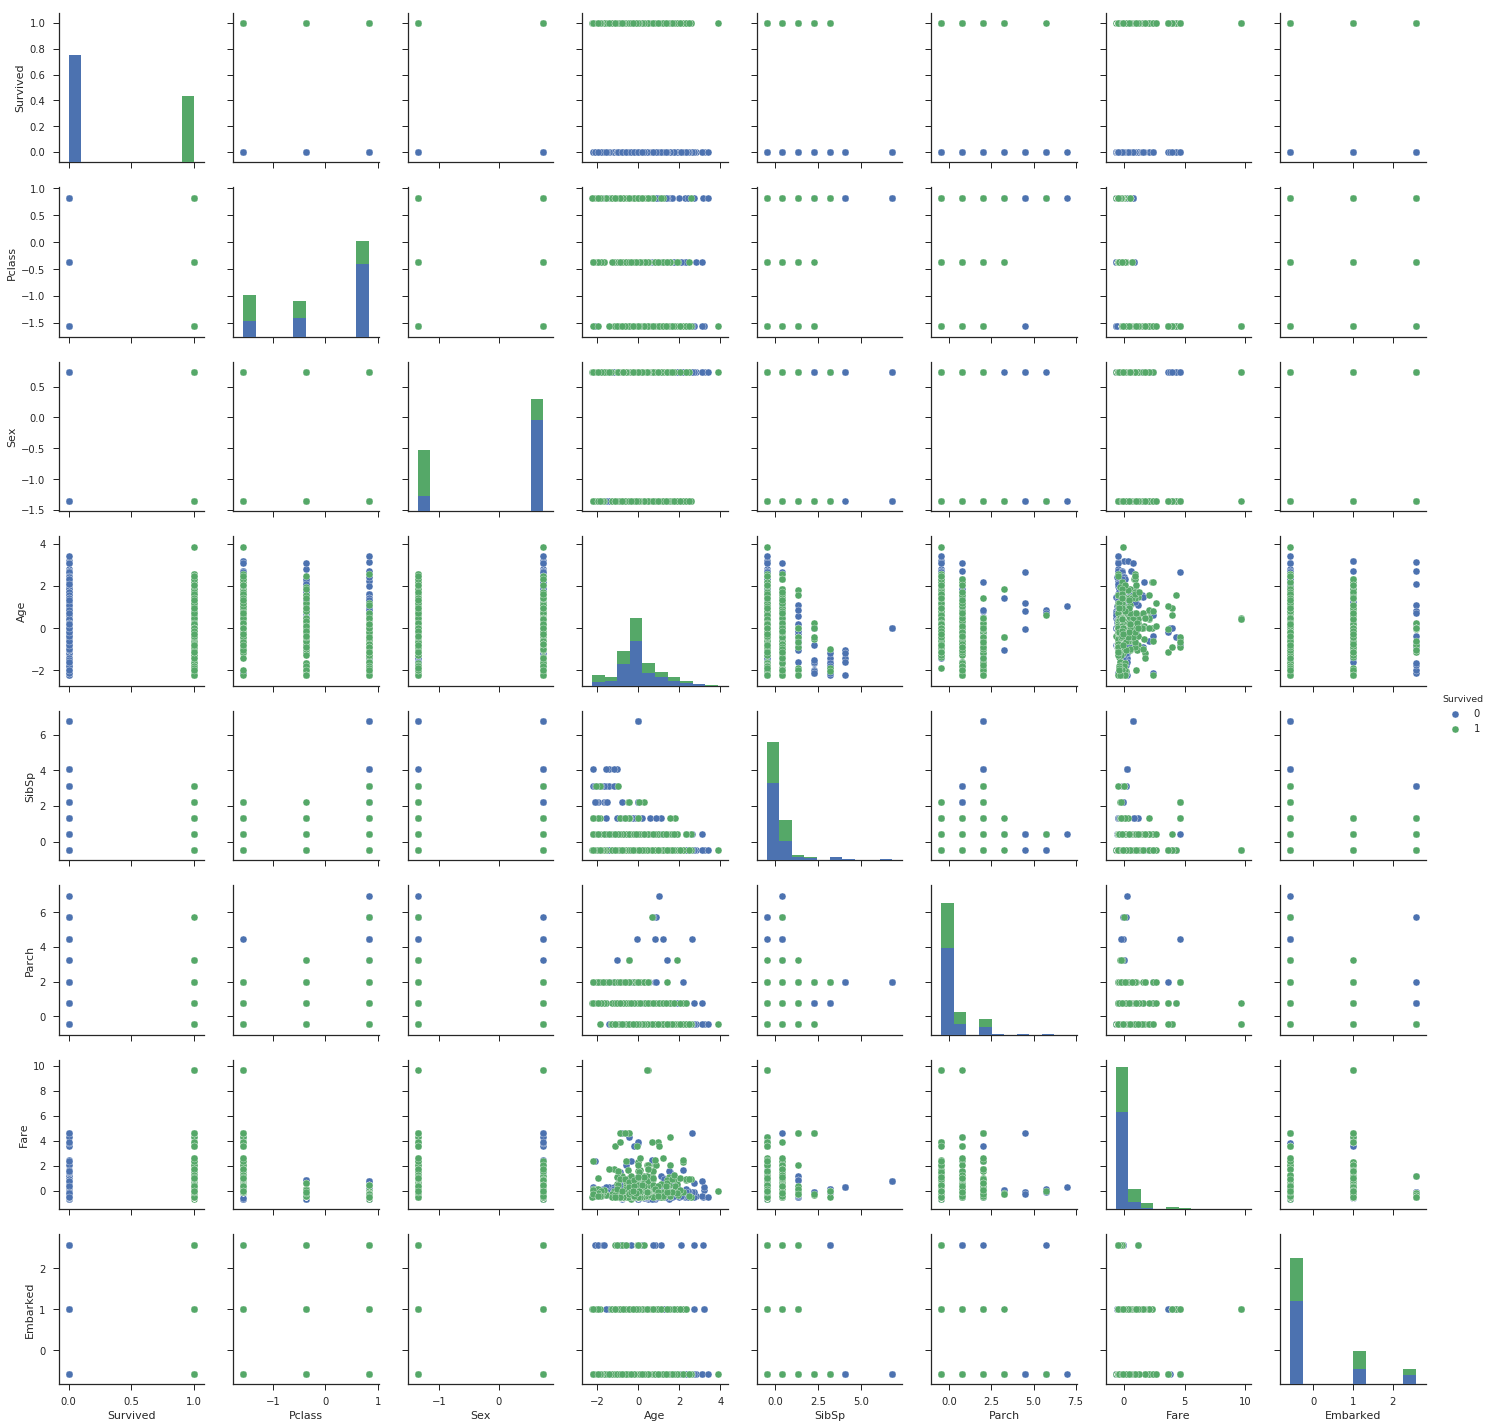

In [49]:
sns.set(style="ticks")
sns.pairplot(df_data, hue='Survived')

Text(0.5,1,'PCA')

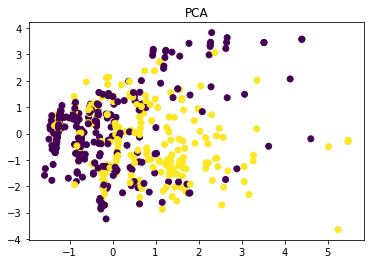

In [7]:
# Principal component analysis
# 2d
pca2 = PCA(n_components=2)
pca2.fit(x_train)
x_transform2 = pca2.transform(x_train)
plt.scatter( x_transform2[:,0], x_transform2[:,1], c = y_train )
plt.title('PCA')

In [53]:
# Logistical fit using sm.Logit
logistic2 = sm.Logit(y_train, x_train)
# fit the model
result = logistic2.fit()
print( result.summary2() )
#print(result.params)
log2_pred = result.predict(x_cv)
# this regression return sigmoid hypothesis. Round it
log2_pred = np.int8( np.round(log2_pred) )
log2_sum = confusion_summary_binary( y_cv, log2_pred,1)


Optimization terminated successfully.
         Current function value: 0.470583
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.293     
Dependent Variable: Survived         AIC:              852.5795  
Date:               2018-04-06 00:54 BIC:              886.1259  
No. Observations:   891              Log-Likelihood:   -419.29   
Df Model:           6                LL-Null:          -593.33   
Df Residuals:       884              LLR p-value:      3.9957e-72
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass       -0.8349    0.1176   -7.0990  0.0000  -1.0654  -0.6044
Sex          -1.3169    0.0990  -13.3057  0.0000  -1.5108  -1.

In [54]:
# fit them all
verbose = 0
# sci-kit learn logistic regression
logistic = linear_model.LogisticRegression()
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
# SVM: linear kernal
linear_svc = SVC(kernel='linear')
# SVM: gaussian kernal
gaussian_svc = SVC(kernel='rbf')
# random forest
randfor = RandomForestClassifier(max_depth=2, random_state=0)
# knn 
n_neighbors = 12
knn = KNeighborsClassifier(n_neighbors)
# build a list
list_o_fits = [logistic, lda, linear_svc, gaussian_svc, randfor, knn]
fit_results = [ sklearn_fit(a_fit, x_train, y_train, x_cv, y_cv, verbose) for a_fit in list_o_fits]
accuracy = np.array( [a_fit["accuracy"] for a_fit in fit_results] );
best_model = {'accuracy': accuracy.max(), 'list_ind': accuracy.argmax(), 'class_name': list_o_fits[accuracy.argmax()].__class__ };
print( best_model )

{'list_ind': 5, 'accuracy': 0.86468646864686471, 'class_name': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>}


In [58]:
# try this over many random sets of the data
num_trials = 10
accuracy_mat = np.zeros( (num_trials, len(list_o_fits) ))
for i in range(num_trials):
    # separate into training sets
    ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
    x_train = x_data.iloc[ind_train]
    x_cv = x_data.iloc[ind_cv]
    y_train = df_train_all.Survived.iloc[ind_train]
    y_cv = df_train_all.Survived.iloc[ind_cv]
    # fit
    fit_results = [ sklearn_fit(a_fit, x_train, y_train, x_cv, y_cv, verbose) for a_fit in list_o_fits]
    accuracy_mat[i,:] = np.array( [a_fit["accuracy"] for a_fit in fit_results] );


In [62]:
# average for the best
print(accuracy_mat)
mean_accuracy = accuracy_mat.mean(axis=0)
best_model = {'accuracy': mean_accuracy.max(), 'list_ind': mean_accuracy.argmax(), 'class_name': list_o_fits[mean_accuracy.argmax()].__class__ };
print( best_model )

[[ 0.78547855  0.77887789  0.76567657  0.81518152  0.74587459  0.78877888]
 [ 0.78877888  0.78877888  0.77887789  0.79207921  0.72277228  0.78547855]
 [ 0.84488449  0.84158416  0.84158416  0.86138614  0.76237624  0.86468647]
 [ 0.77887789  0.77887789  0.7689769   0.82178218  0.79207921  0.80528053]
 [ 0.79537954  0.8019802   0.79207921  0.80528053  0.72937294  0.78547855]
 [ 0.80528053  0.80528053  0.8019802   0.8349835   0.79867987  0.82838284]
 [ 0.81188119  0.82508251  0.82178218  0.84488449  0.81188119  0.82838284]
 [ 0.78877888  0.79207921  0.78877888  0.82508251  0.77227723  0.81188119]
 [ 0.79867987  0.77887789  0.77557756  0.82178218  0.71617162  0.77557756]
 [ 0.78217822  0.78547855  0.77227723  0.81848185  0.76567657  0.81188119]]
{'list_ind': 2, 'accuracy': 0.83608360836083617, 'class_name': <class 'sklearn.svm.classes.SVC'>}


In [13]:
# error analysis for knn
max_neighbors = 20
num_fits = max_neighbors
num_trials = 20
knn_neighbors = np.arange(1,max_neighbors+1)
accuracy_knn_train = np.zeros( num_fits )
accuracy_knn_cv = np.zeros( num_fits )
# loop over numer of neighbors
for nn_ind, nn in enumerate(knn_neighbors):
    knn_temp = KNeighborsClassifier(nn) 
    accuracy_trail_train = np.zeros( (num_trials))
    accuracy_trail_cv = np.zeros( (num_trials))
    for i in range(num_trials):
         # separate into training sets
        ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
        x_train = x_data.iloc[ind_train]
        x_cv = x_data.iloc[ind_cv]
        y_train = df_train_all.Survived.iloc[ind_train]
        y_cv = df_train_all.Survived.iloc[ind_cv]
        # fit it
        knn_temp.fit( x_train, y_train )
        pred_train = knn_temp.predict(x_train)
        pred_cv = knn_temp.predict(x_cv)
        accuracy_trail_train[i] = get_accuracy( y_train, pred_train )
        accuracy_trail_cv[i] = get_accuracy( y_cv, pred_cv )
    accuracy_knn_train[nn_ind] = np.average(accuracy_trail_train)
    accuracy_knn_cv[nn_ind] = np.average(accuracy_trail_cv)


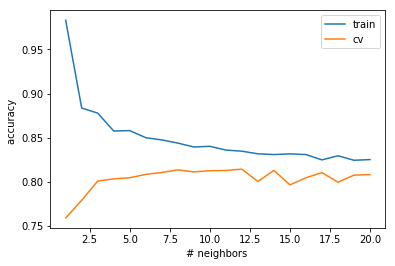

In [14]:
plt.plot( knn_neighbors, accuracy_knn_train, label='train')
plt.plot( knn_neighbors, accuracy_knn_cv, label='cv')
plt.xlabel('# neighbors ')
plt.ylabel('accuracy ')
plt.legend()


In [17]:
# regularization
alpha_fit = [0, 1, 2, 3, 4, 5, 6, 7, 8]
num_fits = len( alpha_fit )
num_trials = 20
accuracy_reg_train = np.zeros( num_fits )
accuracy_reg_cv = np.zeros( num_fits )
# loop over numer of neighbors
for nn_ind, nn in enumerate(alpha_fit):
    print('alpha=', nn)
    fit_temp = Ridge(alpha=nn) 
    accuracy_trail_train = np.zeros( (num_trials))
    accuracy_trail_cv = np.zeros( (num_trials))
    for i in range(num_trials):
         # separate into training sets
        ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
        x_train = x_data.iloc[ind_train]
        x_cv = x_data.iloc[ind_cv]
        y_train = df_train_all.Survived.iloc[ind_train]
        y_cv = df_train_all.Survived.iloc[ind_cv]
        # fit it
        fit_temp.fit( x_train, y_train )
        pred_train = fit_temp.predict(x_train)
        pred_cv = fit_temp.predict(x_cv)
        accuracy_trail_train[i] = get_accuracy( y_train, pred_train )
        accuracy_trail_cv[i] = get_accuracy( y_cv, pred_cv )
    accuracy_reg_train[nn_ind] = np.average(accuracy_trail_train)
    accuracy_reg_cv[nn_ind] = np.average(accuracy_trail_cv)

alpha= 0
alpha= 1
alpha= 2
alpha= 3
alpha= 4
alpha= 5
alpha= 6
alpha= 7
alpha= 8


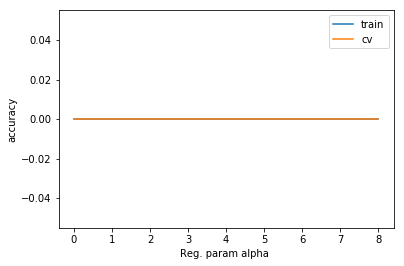

In [18]:
plt.plot( alpha_fit, accuracy_reg_train, label='train')
plt.plot( alpha_fit, accuracy_reg_cv, label='cv')
plt.xlabel('Reg. param alpha ')
plt.ylabel('accuracy')
plt.legend()

In [68]:
df = pd.DataFrame({"a": [0, 1, 2], "b": [2,3,4]} )

In [70]:
if "b" in df:
    print('yes')
else:
    print("no")

yes


In [73]:
df.join({"c":[1,2,3]})

AttributeError: 'builtin_function_or_method' object has no attribute 'is_unique'